<a href="https://colab.research.google.com/github/mark-bell-tna/ComputationalAccess/blob/main/UKGWA_London_2012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests;      #used for connecting to the API
import sys
from time import sleep
from math import log
import os
from urllib.request import urlopen
import re
from operator import itemgetter
from matplotlib import pyplot as plt

In [2]:
if 'google.colab' in str(get_ipython()):
    environment = "Colab"
elif 'BINDER_SERVICE_HOST' in os.environ:
    environment = "Binder"
else:
    environment = "Unknown"

In [3]:
# For development purposes only when making changes in Github
import shutil
shutil.rmtree('ComputationalAccess')

In [4]:
if environment == "Colab":
    !git clone https://github.com/mark-bell-tna/ComputationalAccess.git
    sys.path.insert(0, 'ComputationalAccess')
    github_data = "ComputationalAccess/Data/"
    os.listdir(github_data)
    # Connect to gdrive
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_folder = "/content/gdrive/My Drive/Data/"
else:
    github_data = "Data/"
    data_folder = "Data/"


Cloning into 'ComputationalAccess'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 128 (delta 6), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (128/128), 112.95 KiB | 718.00 KiB/s, done.
Resolving deltas: 100% (64/64), done.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
from ukgwa_index import UKGWAIndex
from text_utils import SuffixTree, text_to_parts
from web_structure import UKGWAStructure
from ukgwa_query import QueryEngine
from cdx_indexer import TemporalIndexer
from ukgwa_textindex import UKGWATextIndex

In [49]:
# Get entries from AtoZ index

refresh = False

print("Getting index...")
ATOZ = UKGWAIndex()
if refresh:
    ATOZ.indexfromweb()  # Read the A to Z index from the UKGWA website
else:
    ATOZ.indexfromfile(data_folder + "atoz_index.txt")  # Read from a saved file

print("Loaded index...")

Getting index...
Loaded index...


In [ ]:
# Updated the entries with Discovery catalogue references

ATOZ.discoveryfromfile(github_data + "discovery_ukgwa_links.txt")

In [ ]:
# Test the last command worked - should see a catalogue reference in last position of list
# If it says 'N' then try a few other numbers.
ATOZ.index['UKGWA.100']

['UKGWA.100',
 'Advisory Panel on Country Information (APCI) (http://apci.homeoffice.gov.uk)',
 '*',
 'http://apci.homeoffice.gov.uk/',
 'HO 437']

In [ ]:
# Only run this if you want to save the results of "indexfromweb" for next time
ATOZ.indextofile(data_folder + "atoz_index.txt")

In [54]:
# Index the text of the index to make it searchable and to get common ngrams

TI = UKGWATextIndex(stop_words = set(['on','for','and','of','&','the','in','to']))

print("Loading text to index...")
for key in ATOZ:
    entry_type = ATOZ.get_field(key, 'CAT')
    if entry_type != '*':  # Archived web sites
        continue    # skip twitter, youtube, etc.
    w_p = text_to_parts(ATOZ.get_field(key, 'TEXT'))
    i = 0
    for p in w_p:
        if p[3] == "web":
            continue
        i += 1
        TI.add_tokens(p[0].split(" "), key + "." + str(i))

print("Loaded")


Loading text to index...
Loaded


In [55]:
# Print examples of top N common ngrams

print("Getting phrases...")
ph = TI.get_phrases(min_count=30, min_length=2)
ph.sort(key=itemgetter(3), reverse=True)

# Change N to view more phrases
N = 5
topNindex = {}
for row in ph[0:N]:
    print(row)

Getting phrases...
[['National', 'Health', 'Service'], 3, 150, 150]
[['GOV.UK', 'Blog'], 2, 144, 144]
[['Advisory', 'Committee'], 2, 59, 59]
[['National', 'Institute', 'Health'], 3, 47, 47]
[['Department', 'Health'], 2, 44, 44]


In [56]:
WS = UKGWAStructure()

for identifier in ATOZ:
    url = ATOZ.get_field(identifier, 'URL')
    WS.add_entry(url, identifier)

In [57]:
Q = QueryEngine()
Q.add_view('TextIdx', TI)
Q.add_view('Domain', WS)
Q.add_view('AtoZ', ATOZ)

In [58]:
search_terms = ['Olympic Games','London 2012']
search_terms = [s.split(' ') for s in search_terms]
search_terms

[['Olympic', 'Games'], ['London', '2012']]

In [59]:
match_ids = [x for x in Q.filter_view('TextIdx', 'NGRAM', '=', *search_terms)]
print("Matched:",len(match_ids),'Ids')

(['Olympic', 'Games'], ['London', '2012'])
Matched: 33 Ids


In [60]:
# Set query to include matching ids
_ = [Q.include(x[:-2]) for x in match_ids]

In [61]:
# Summarise included ids by web domain
domain_summary = {}
for identifier in Q:
    url_parts = WS.index[identifier]
    dt = WS.domaintotree(url_parts[WS.fields['NETLOC']], strip_www=True)
    dom_name = ".".join(reversed(dt[:2]))
    if dom_name in domain_summary:
        domain_summary[dom_name] += 1
    else:
        domain_summary[dom_name] = 1

sorted_domains = sorted([(k,v) for k,v in domain_summary.items()], key=itemgetter(1), reverse=True)
print(sorted_domains)

[('london2012.com', 18), ('gov.uk', 6), ('org.uk', 1), ('tumblr.com', 1), ('visitlondon.com', 1), ('cslondon.org', 1), ('nhs.uk', 1), ('mod.uk', 1), ('mylondon2012.com', 1)]


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

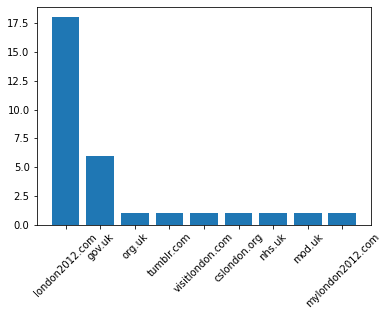

In [62]:
# Bar chart of the figures derived above
x,y = zip(*sorted_domains)
plt.bar(x,y)
plt.xticks(rotation=45)

In [63]:
T = TemporalIndexer()
Q.add_view("Temp", T)

In [64]:
# This takes quite a while to run
# Get snapshot data from the CDX API
for identifier in Q:
    T.add_entry(ATOZ.get_field(identifier, 'URL'), identifier)
print("Finished")

In [65]:
# View a sample temporal record
print("Field names:",sorted([[x[1],x[0]] for x in T.fields.items()], key=itemgetter(0)))
for t in T:
  print(T.lookup(t))
  break

Field names: [[0, 'MIN'], [1, 'MAX'], [2, 'COUNT'], [3, 'CDX']]
[20110202123526, 20130228085626, 31, <cdx_reader.CDXReader object at 0x7f2572bc84a8>]


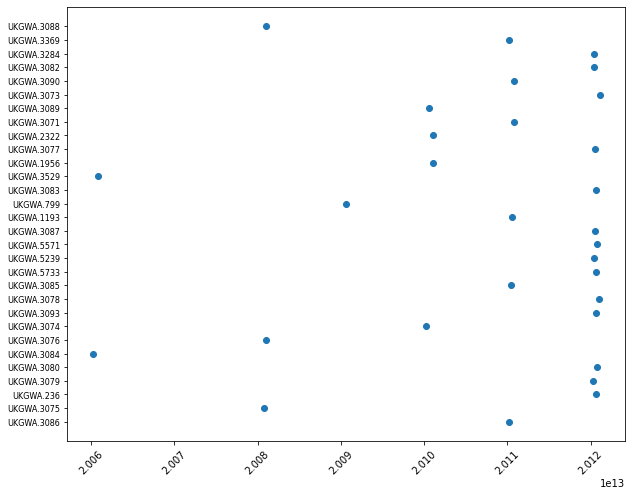

In [88]:
# Draw chart of earliest snapshots by site
first_last_snapshots = [[idx] + T.lookup(idx, ['MIN','MAX']) for idx in Q]
first_last_snapshots = [x for x in first_last_snapshots if x[1] != 90000000000000]  # Hide this in Temporal class. Odd bug in snapshot crawling code causes them
first_last_snapshots = [x for x in first_last_snapshots if x[2] != 0]
x,y,z = zip(*first_last_snapshots)
plt.figure(figsize=(10,8))
plt.scatter(y,x)
plt.xticks(rotation=45)
plt.yticks(fontsize=8)
plt.show()

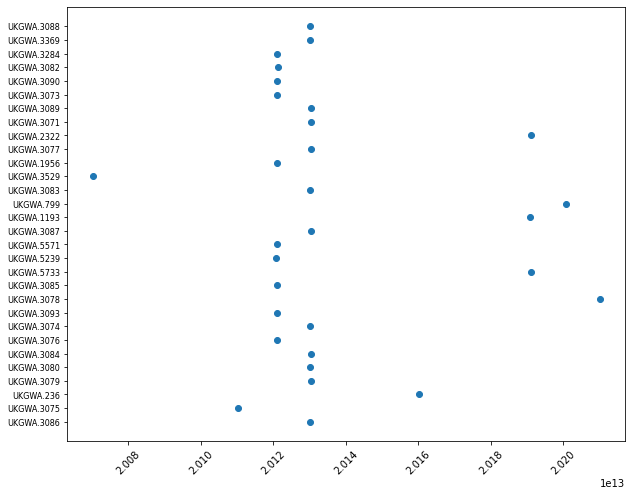

In [75]:
# Same chart for latest snapshots by site
plt.figure(figsize=(10,8))
plt.scatter(z,x)
plt.xticks(rotation=45)
plt.yticks(fontsize=8)
plt.show()

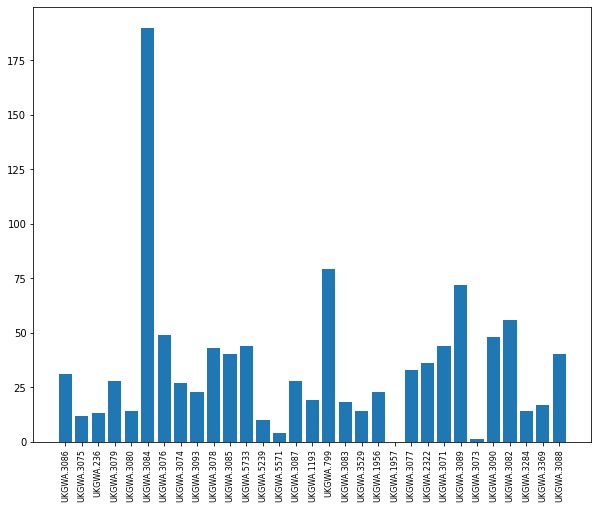

In [95]:
# Plot by snapshot count
snapshot_counts = [[idx] + T.lookup(idx, ['COUNT']) for idx in Q]
x,y = zip(*snapshot_counts)
plt.figure(figsize=(10,8))
plt.bar(x,y)
plt.xticks(rotation='vertical')
plt.xticks(fontsize=8)
plt.show()

In [97]:
# What are the top N results?
N = 5
snapshot_counts.sort(key=itemgetter(1),reverse=True)
for idx in snapshot_counts[0:N]:
    print(ATOZ.lookup(idx[0]), "Snapshots:",idx[1])

['UKGWA.3084', 'London 2012 – Olympic Games', '*', 'http://www.london2012.com/', 'PF 15'] Snapshots: 190
['UKGWA.799', 'Commission for a Sustainable London 2012', '*', 'http://www.cslondon.org/', 'PF 73'] Snapshots: 79
['UKGWA.3089', 'London 2012 – Shop', '*', 'http://shop.london2012.com/', 'PF 161'] Snapshots: 72
['UKGWA.3082', 'London 2012 – Mascots', '*', 'https://mascot-games.london2012.com/', 'PF 142'] Snapshots: 56
['UKGWA.3076', 'London 2012 – Inspire Programme', '*', 'http://www.london2012.com/get-involved/inspire-programme/index.php', 'PF 131'] Snapshots: 49


In [89]:
# Get entries where first snapshot is less than 1/1/2011
t_filt = Q.filter_view("Temp", 'MIN', '<', 20110101000000)
for t in t_filt:
    print(t, ATOZ.lookup(t))

UKGWA.3075 ['UKGWA.3075', 'London 2012 – Going for Gold along with the Get Set London Roadshow Blog (http://www.london2012.com/blog/2008/03/20/going-for-gold-along-with-the-get-set-london-roadshow.php)', '*', 'http://www.london2012.com/blog/2008/03/20/going-for-gold-along-with-the-get-set-london-roadshow.php', 'PF 74']
UKGWA.3084 ['UKGWA.3084', 'London 2012 – Olympic Games', '*', 'http://www.london2012.com/', 'PF 15']
UKGWA.3076 ['UKGWA.3076', 'London 2012 – Inspire Programme', '*', 'http://www.london2012.com/get-involved/inspire-programme/index.php', 'PF 131']
UKGWA.3074 ['UKGWA.3074', 'London 2012 – Going for Gold along with the Get Set London Roadshow (http://www.london2012.com/blog/2008/03/going-for-gold-along-with-the-get-set-london-roadshow.php)', '*', 'http://www.london2012.com/blog/2008/03/going-for-gold-along-with-the-get-set-london-roadshow.php', 'PF 74']
UKGWA.799 ['UKGWA.799', 'Commission for a Sustainable London 2012', '*', 'http://www.cslondon.org/', 'PF 73']
UKGWA.3529 [

In [85]:
# Get entries where first snapshot is after the Games (roughly)
t_filt = Q.filter_view("Temp", 'MIN', '>', 20120901000000)
for t in t_filt:
    print(t, ATOZ.lookup(t))

UKGWA.3078 ['UKGWA.3078', 'London 2012 – Learning Legacy (http://learninglegacy.independent.gov.uk/)', '*', 'http://learninglegacy.independent.gov.uk/', 'PF 141']
UKGWA.1957 ['UKGWA.1957', 'Foreign and Commonwealth Office (FCO) – Pope Benedict sends message of support to London Olympic Games', '*', 'http://ukinholysee.fco.gov.uk/en/news/?view=News&id=791576182', 'FCO 144']
UKGWA.3073 ['UKGWA.3073', 'London 2012 – Get Set', '*', 'http://original-getset.london2012.com/en/home', 'PF 172']


In [87]:
T.lookup('UKGWA.1957')

[90000000000000, 0, 0, <cdx_reader.CDXReader at 0x7f256a4e6198>]

In [86]:
# Get entries where last snapshot is before the Games (roughly)
t_filt = Q.filter_view("Temp", 'MAX', '<', 20120726000000)
for t in t_filt:
    print(t, ATOZ.lookup(t))

UKGWA.3075 ['UKGWA.3075', 'London 2012 – Going for Gold along with the Get Set London Roadshow Blog (http://www.london2012.com/blog/2008/03/20/going-for-gold-along-with-the-get-set-london-roadshow.php)', '*', 'http://www.london2012.com/blog/2008/03/20/going-for-gold-along-with-the-get-set-london-roadshow.php', 'PF 74']
UKGWA.3529 ['UKGWA.3529', 'National Health Service (NHS) – Fit for London 2012', '*', 'http://www.fitforlondon2012.nhs.uk/', 'JA 74']
UKGWA.1957 ['UKGWA.1957', 'Foreign and Commonwealth Office (FCO) – Pope Benedict sends message of support to London Olympic Games', '*', 'http://ukinholysee.fco.gov.uk/en/news/?view=News&id=791576182', 'FCO 144']


In [90]:
# Reset the query selection
Q.clear()
_ = [Q.include(x[:-2]) for x in match_ids]

In [91]:
# Summarise by catalogue series
series_summary = {}
for identifier in Q:
    entry = ATOZ.lookup(identifier)
    series = entry[ATOZ.fields['CATREF']].split(" ")[0]
    if series in series_summary:
        series_summary[series] += 1
    else:
        series_summary[series] = 1

sorted_series = sorted([(k,v) for k,v in series_summary.items()], key=itemgetter(1), reverse=True)
print(sorted_series)
# These codes will only be meaningful with a catalogue lookup

[('PF', 23), ('FCO', 3), ('N', 2), ('DFT', 1), ('JA', 1), ('DEFE', 1)]


In [ ]:
# Now what?

# 